# Stroke Prediction Project

We work with a stroke prediction dataset from Kaggle website. It contains data regardig patients who likely suffered a stroke. In addition to the target variable, 0 (no stroke) or 1 (stroke) we are given some attributes related to the lifestyle of the patient. These attributes include factors such as Blood pressure, Smoking Habits, Type of work, Age of Patient etc.

## Goal
Build a classification model which, depending on the input given predicts how likely a patient is to suffer from a stroke. Depending on the likelihood of getting a stroke, preventive actions can be taken by the patient so as to not to be sorry later.

In [1]:
# packages are being loaded from /Users/jayantsingh/.ipython/profile_default/startup.py.it loads packages
# automatically on starting jupyter, make sure to call %matplotlib inline here in the cell

%matplotlib inline

In [2]:
# Read in the Input Data
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke_data.shape

(5110, 12)

In [3]:
stroke_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [4]:
stroke_label_cnt = stroke_data.groupby(['stroke'])['id'].count()
stroke_label_cnt

stroke
0    4861
1     249
Name: id, dtype: int64

It is a highly imbalanced dataset, where 1 denotes stroke has occured and 0 otherwise. The goal is to correctly classify whether a patient is likely to have a stroke or not.

## Data Cleaning And Preprocessing


### Missing Data
As a first step it will be helpful to look for columns with missing values. As a rule of thumb, columns with more than seventy percent of missing data can be excluded from subsequent analysis. 

In [5]:
#run the function defined in .py script, i helps with variables defined interactively

%run -i clean_data.py
clean_data(stroke_data);

Fortunatly, we don't have to delete any columns, since almost all of them are fully populated. The column `bmi` is numeric and has close to 4 percent missing values. For convenience and sake of completeness, we'll impute it by median of the non-missing data.  

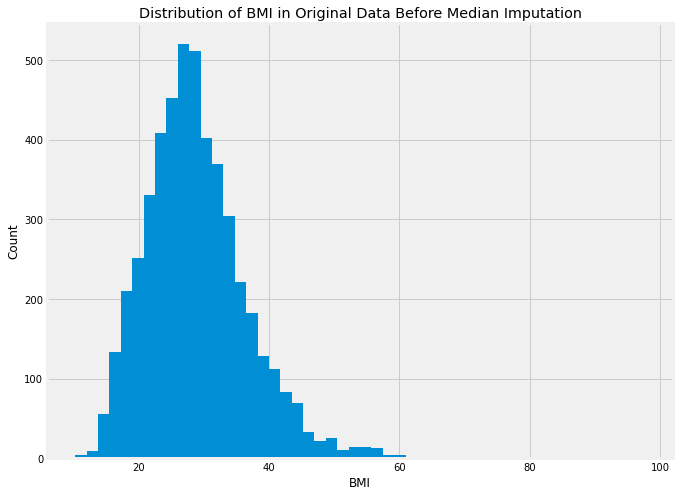

In [6]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist(stroke_data['bmi'],bins=50)
ax.set_xlabel('BMI')
ax.set_ylabel('Count')
ax.set_title('Distribution of BMI in Original Data Before Median Imputation')
plt.show()

The average BMI is identical across both genders. Hence BMI imputation can be done using median value for the entire dataset.  

BMI distribution is roughly normal. It has some missing values, hence we can do median imputation.

In [6]:
#make a copy to avoid overwriting
stroke_data_complete = stroke_data.copy()
stroke_data_complete['bmi'] = stroke_data_complete['bmi'].fillna(
    stroke_data_complete['bmi'].median())

In [7]:
#Drop values with Other gender
stroke_data_complete = stroke_data_complete.loc[stroke_data_complete.gender!='Other']

In order to save space, we'll save the object variables as categoricals, float64 as float32, as well as convert int64 to int32.
### Change DatatTypes To Save Memory Usage

In [8]:
stroke_data_complete[['gender', 'ever_married', 'work_type','Residence_type',\
                      'smoking_status', 'stroke']] = stroke_data_complete[['gender', 'ever_married', 'work_type',\
                                                                 'Residence_type', 'smoking_status', 'stroke']].\
                                                                 astype('category')

stroke_data_complete[['hypertension', 'heart_disease']] = stroke_data_complete[['hypertension', 'heart_disease', \
                                                                            ]].astype('category')
stroke_data_complete[['age', 'avg_glucose_level', 'bmi']] = stroke_data_complete[['age', 'avg_glucose_level', \
                                                                                          'bmi']].astype('float32')

In [9]:
#get glimpse of the data
stroke_data_complete.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.690002,36.599998,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.210007,28.100000,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.919998,32.500000,never smoked,1




To begin with the EDA process, we'll look at scatter plot between avergae glucose level and bmi, and group it by the stroke.




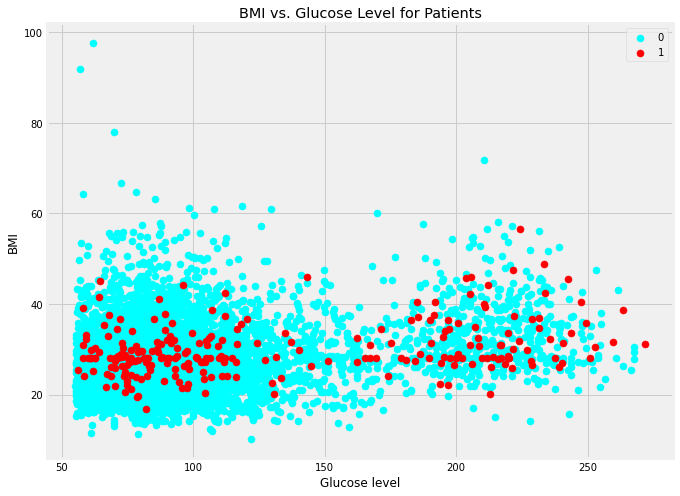

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
colormap = np.array(['aqua','r'])
#for i in [0,1]:
#ax.scatter(x= stroke_data_complete['avg_glucose_level'], y=stroke_data_complete['bmi'], \
 #          c=colormap[stroke_data_complete['stroke']],marker= 'o', s=50 )

for i in [0,1]:
    ax.scatter(x= stroke_data_complete['avg_glucose_level'][stroke_data_complete['stroke']==i],\
               y=stroke_data_complete['bmi'][stroke_data_complete['stroke']==i], \
               c=colormap[i], marker= 'o', s=50, label = i )
    
#plt.gray()
ax.legend()
ax.set_xlabel('Glucose level')
ax.set_ylabel('BMI')
ax.set_title('BMI vs. Glucose Level for Patients')
plt.show()

In the above scatter plot, we can easily observe that it doesn't necessarily mean that people with stroke have high Glucose level. Moreover the dataset is highly skewed, with red circles denoting patients with Stroke and blue otherwise.

## K-Means Clustering

As an additional step, we want to perform clustering here based on BMI and Glucose level and group the patients based on it. K-means clustering involves following two steps;

* Assign data points to clusters, based on distance from the centorids, and
* Revise the centroids based on the data points assigned to it.

For simplicity, we'll use above 2 variables Glucose and BMI for cluster allocation.

In [13]:
# randomly initialize centroids, we can randomly permute the data points and choose say first 2 examples, assuming 
#2 clusters as per the scatterplot

data_cluster = stroke_data_complete[['avg_glucose_level','bmi']].copy()
shuffled_data = data_cluster.sample(frac=1)



In [14]:
#next we'll choose first two data points as initialized centroids
init_centroids = shuffled_data.iloc[0:3,:]


In [15]:
#function to assign clusters for each datapoint

def assign_clusters(data, centroids):
    #print(data,centroids)
    
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    return cluster_assignment
    

In [16]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    
    for i in range(k):
        # Select all data points that belong to cluster i using list of Boolean values
        member_data_points = data[cluster_assignment==i]
        
        # Compute the mean of the data points, across the rows
        centroid = member_data_points.mean(axis=0)
        
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

**Asessing Convergence**

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters. In above equation, $x_i$ represent the data points and $\mu_{j}$ represents the mean of cluster $j$.

In [17]:
def compute_heterogeneity(data, centroids, clusters, k):
    heterogenity=0
    
    for i in range(k):
        data_points = data[clusters==i]
        
        if data_points.shape[0]>0:
            distance_centroids = pairwise_distances(data_points, [centroids[i]], metric='euclidean')
            heterogenity += np.sum(distance_centroids**2)
    return heterogenity
        

In [18]:
def run_kmeans(initial_centroids, data, maxiter,k):

    centroids = initial_centroids[:]
    record_heterogeneity = []
    prev_cluster_assignment = None
    
    for itr in range(maxiter): 
        
        cluster_assignment = assign_clusters(data, centroids)
        #print(cluster_assignment)
        centroids =  revise_centroids(data, k, cluster_assignment)
        #print(cluster_assignment, prev_cluster_assignment)
        
        if (prev_cluster_assignment == cluster_assignment).all():
            print(itr,'no change')
            break
            
         # Record heterogeneity convergence metric
        score = compute_heterogeneity(data, centroids, cluster_assignment, k)
        #print(score)
        record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
       
    return centroids, cluster_assignment, record_heterogeneity

In [19]:
centroids, cluster_assignment, heterogeneity_record = run_kmeans(np.array(init_centroids), data_cluster, 100,3)

24 no change


It seems this clustering algorithm did converge in 24 iterations. In other words, it has stabilized.

In [21]:
centroids

array([[ 78.15617 ,  28.423588],
       [209.4579  ,  32.62982 ],
       [115.33059 ,  28.095253]], dtype=float32)

The final centroids tend to make sense depending on the scatter plot visualized above. 

## Univariate Analysis
To explore the data more, we'll perform some relationship analysis between the attributes and target variable. To begin with, do we some asscociation between hypertension and stroke. We'll compute $\chi$ square coefficient to measure the association. 

In [22]:
#Hypertension and Stroke

table_hypertension = pd.crosstab(stroke_data_complete['hypertension'], stroke_data_complete['stroke'])
stat_hyper, p, dof, expected = stats.chi2_contingency(table_hypertension)
p;

Using the significantly low value of p, we can reject the null hypothes that there is no dependence between hypertension and stroke. In order to perform feature selection, we can also compute the Cramer's statistic using $\chi$ square statistic.

In [23]:
cramer_stats_hyper_stroke = math.sqrt(stat_hyper/(stroke_data_complete.shape[0]*1))
cramer_stats_hyper_stroke

0.12635884599246405

In [24]:
#heart disease and stroke

table_heart = pd.crosstab(stroke_data_complete['heart_disease'], stroke_data_complete['stroke'])
stat_heart, p, dof, expected = stats.chi2_contingency(table_heart)
p;

In [25]:
cramer_stats_heart_stroke = math.sqrt(stat_heart/(stroke_data_complete.shape[0]*1))
cramer_stats_heart_stroke

0.1328942441984636

In [26]:
#smoking status and stroke

table_smoking = pd.crosstab(stroke_data_complete['smoking_status'], stroke_data_complete['stroke'])
stat_smoke, p, dof, expected = stats.chi2_contingency(table_smoking)
p;

In [27]:
cramer_stats_smoking_stroke = math.sqrt(stat_smoke/(stroke_data_complete.shape[0]*1))
cramer_stats_smoking_stroke

0.07563358927668186

Interestingly, smoking is not so closely associated with the stroke variable.

In [32]:
#Marriage status and stroke

table_marriage = pd.crosstab(stroke_data_complete['ever_married'], stroke_data_complete['stroke'])
stat_marriage, p, dof, expected = stats.chi2_contingency(table_marriage)
p

1.6862856191673454e-14

In [33]:
cramer_stats_marriage_stroke = math.sqrt(stat_marriage/(stroke_data_complete.shape[0]*1))
cramer_stats_marriage_stroke

0.10734232198815681

In [35]:
label_cnt = stroke_data_complete.groupby(['stroke'],\
                                                  observed=True)['id'].count()
label_cnt = label_cnt.reset_index()
label_cnt.rename(columns={'id':'Total_Cnt'}, inplace=True)

In [37]:
marriage_label_cnt = stroke_data_complete.groupby(['ever_married','stroke'],\
                                                  observed=True)['id'].count()
marriage_label_cnt = marriage_label_cnt.reset_index()
marriage_label_cnt.rename(columns={'id':'Cases_Cnt'}, inplace=True)
marriage_label_cnt

,ever_married,stroke,Cases_Cnt
0,Yes,1,220
1,Yes,0,3133
2,No,1,29
3,No,0,1727


In [38]:
marriage_stroke_data = pd.merge(marriage_label_cnt, label_cnt, left_on =['stroke'],\
                    right_on= ['stroke'], how='inner')
marriage_stroke_data['Stroke_pct']  = np.round((marriage_stroke_data['Cases_Cnt']/marriage_stroke_data['Total_Cnt'])*100,2)
marriage_stroke_data

,ever_married,stroke,Cases_Cnt,Total_Cnt,Stroke_pct
0,Yes,1,220,249,88.35
1,No,1,29,249,11.65
2,Yes,0,3133,4860,64.47
3,No,0,1727,4860,35.53


Using the low value of p, it seems being married or not does have significant association with the target variable.

### Relation Between Glucose Level And Stroke
Since Glucose Level is continuous, it makes sense to bin it and look at the relation between discretisized variable and target variable.

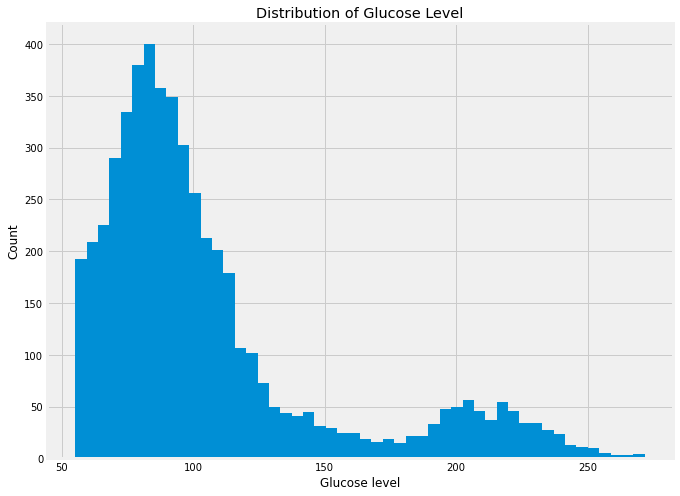

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist(stroke_data_complete['avg_glucose_level'],bins=50)
ax.set_xlabel('Glucose level')
ax.set_ylabel('Count')
ax.set_title('Distribution of Glucose Level')
plt.show()

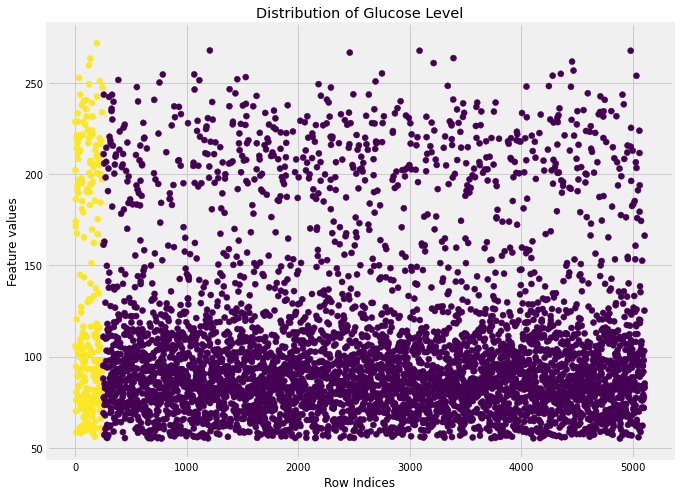

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(range(len(stroke_data_complete['avg_glucose_level'])),stroke_data_complete['avg_glucose_level'],\
           c=stroke_data_complete['stroke'])
ax.set_xlabel('Row Indices')
ax.set_ylabel('Feature values')
ax.set_title('Distribution of Glucose Level')
plt.show()

Above scatter plot is drawn between the data indices and values for glucose level, and color coded by target variable. For sure we have lots of data points with glucose level less than 150, and this is true for both classes.

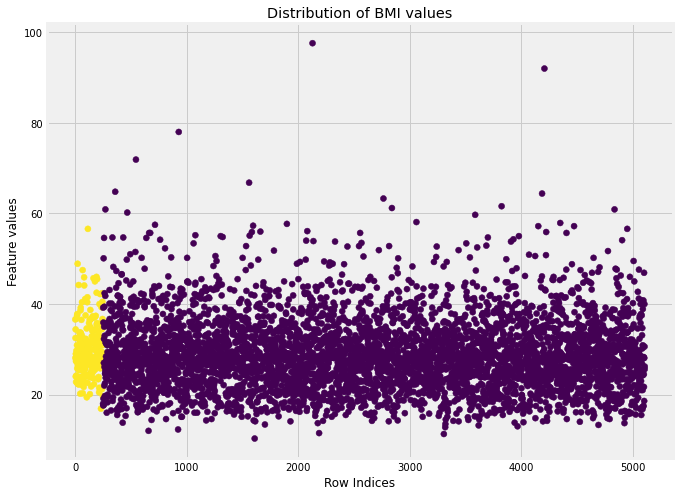

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(range(len(stroke_data_complete['bmi'])),stroke_data_complete['bmi'],\
           c=stroke_data_complete['stroke'])
ax.set_xlabel('Row Indices')
ax.set_ylabel('Feature values')
ax.set_title('Distribution of BMI values')
plt.show()

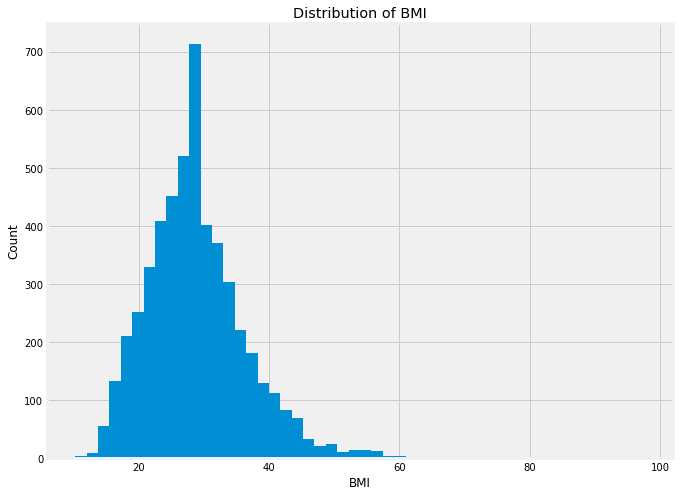

In [14]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist(stroke_data_complete['bmi'],bins=50)
ax.set_xlabel('BMI')
ax.set_ylabel('Count')
ax.set_title('Distribution of BMI')
plt.show()

**Important**: Since median has been used to impute BMI value, we get a peak close to mean value.

In [29]:
#Cut into 4 bins of equal frequency counts

stroke_data_complete['glucose_level_quartile'] = pd.qcut(stroke_data_complete['avg_glucose_level'], q=4)
stroke_data_complete['glucose_level_quartile'].value_counts();

It will be interesting to see, for stroke patients, do we see relation between gender and glucose levels.

In [30]:
#filter for stroke patients
stroke_data = stroke_data_complete.loc[stroke_data_complete.stroke==1]
gender_cnt = stroke_data.groupby(['gender'])['id'].count()
gender_cnt = gender_cnt.reset_index()
gender_cnt.rename(columns={'id':'gender_cnt'}, inplace=True)
gender_cnt;

In [31]:
gender_glucose_level_cnt =  stroke_data.groupby(['gender','glucose_level_quartile'])['id'].count()
gender_glucose_level_cnt = gender_glucose_level_cnt.reset_index()
gender_glucose_level_cnt.rename(columns={'id':'count'}, inplace=True)
gender_glucose_level_cnt;

In [33]:
joined_gender_glucose_level = pd.merge(gender_glucose_level_cnt, gender_cnt, left_on= 'gender',\
                                       right_on= 'gender', how='inner')
joined_gender_glucose_level['stroke_pct'] = np.round((joined_gender_glucose_level['count']/ joined_gender_glucose_level['gender_cnt'])*100,\
                                             2)


In [36]:
plot_data =  joined_gender_glucose_level[['gender','glucose_level_quartile','stroke_pct']].copy()
plot_data.index = plot_data.gender
plot_data.drop('gender', axis=1,inplace=True)
plot_data_pivoted = plot_data.pivot(columns='glucose_level_quartile', values='stroke_pct')
plot_data_pivoted

glucose_level_quartile,"(55.119, 77.24]","(77.24, 91.88]","(91.88, 114.09]","(114.09, 271.74]"
gender,,,,
Female,27.66,15.60,19.15,37.59
Male,14.81,14.81,19.44,50.93


From above pivot data, we see that in the lower glucose range $[55,77]$ females have a higher percentage of stroke cases as compared to males. On the other hand, 50 percent of male stroke cases fall in the upper range 3rd quartile in comparison to only 37 percent for females. From this chart, we can say that a male patient with stroke is at least 50 percent likely to have the glucose level in the uppe quartile, whereas the women patients are not so likely to have a high glucose level. 

Another way to look at interaction can be done as follows;
* For every quartile of glucose level and gender, obtain count of cases,
* Next, find percent of stroke cases for each gender and quartile level.

In [37]:
gender_glucose_label_cnt = stroke_data_complete.groupby(['gender','glucose_level_quartile','stroke'], observed=True)['id'].count()
gender_glucose_label_cnt = gender_glucose_label_cnt.reset_index()
gender_glucose_label_cnt.rename(columns={'id':'Count'}, inplace=True)

In [38]:
gender_glucose_cnt = stroke_data_complete.groupby(['gender','glucose_level_quartile'],\
                                                  observed=True)['id'].count()
gender_glucose_cnt = gender_glucose_cnt.reset_index()
gender_glucose_cnt.rename(columns={'id':'Total_Cnt'}, inplace=True)
gender_glucose_cnt;

In [39]:

gender_glucose_joined_data = pd.merge(gender_glucose_cnt, gender_glucose_label_cnt, left_on =['gender','glucose_level_quartile'],\
                    right_on= ['gender','glucose_level_quartile'], how='inner')
gender_glucose_joined_data;

In [40]:
#compute percent of stroke cases for each gender and glucose level
gender_glucose_joined_data_stroke = gender_glucose_joined_data.loc[gender_glucose_joined_data.stroke==1].copy()
gender_glucose_joined_data_stroke['stroke_pct'] = np.round((gender_glucose_joined_data_stroke['Count']/gender_glucose_joined_data_stroke['Total_Cnt'])*100,2)
gender_glucose_joined_data_stroke;

In [41]:
gender_glucose_joined_data_stroke.index = gender_glucose_joined_data_stroke.gender
gender_glucose_joined_data_stroke.drop('gender', axis=1, inplace=True)
gender_glucose_data_pivoted = gender_glucose_joined_data_stroke.pivot(columns='glucose_level_quartile',\
                                                               values='stroke_pct')

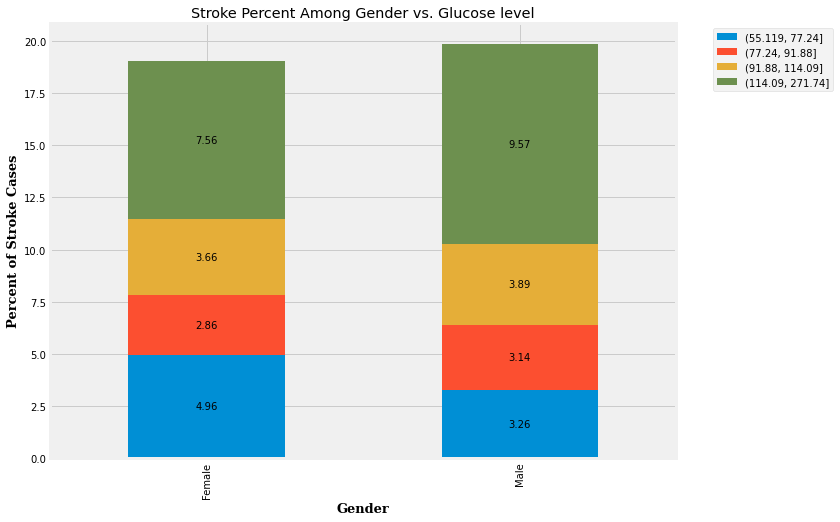

In [42]:
font = {'family':'serif',
       'color':'black',
       'weight':'bold',
       'size':13}

ax = gender_glucose_data_pivoted.plot(kind='bar', stacked=True, figsize=(10,8))
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x=rect.get_x()
    y=rect.get_y()
    label_text = f'{height:0.2f}'
    label_x=x+width/2
    label_y=y+height/2
    ax.text(label_x,label_y,label_text, ha='center', va='center')
ax.set_title('Stroke Percent Among Gender vs. Glucose level')
ax.set_xlabel('Gender', fontdict= font)
ax.set_ylabel('Percent of Stroke Cases', fontdict=font)
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

Above data tells us that irrespective of the gender, higher glucose level in the range(114, 271) has significant percentage of stroke cases. Hence, we can rule out interaction between Gender and Glucose level.

#### Entropy Based Binning 

Try another binning say deciles approach and compare the information gain using both approaches. That can be one startegy on how to choose the proper binning startegy. In order to calculate Information gain related to an attribute, we will execute following steps;
* Compute the overall entropy for the dataset




                

 $$ Entropy(S) = - \sum_{i} p_{i} \log_{2}p_{i}$$
 
 * Calculate Information gain for the attribute
 
 
 $$Gain(S,A) = Entropy(S) - \sum_{v \in values(A)} \frac{|S_{v}|}{|S|}  Entropy(S_{v})$$

In [43]:
def compute_entropy(df):
    stroke_prop = df['stroke'].astype('int32').mean()
    safe_prop = 1-stroke_prop
    #print(safe_prop,stroke_prop)
    entropy = -((stroke_prop*math.log(stroke_prop,2)) + (safe_prop*math.log(safe_prop,2)))
    return entropy

    

In [44]:
#First we'll calculate the overall entropy for the data

overall_entropy= compute_entropy(stroke_data_complete)


In [45]:
#next we'll loop over the values for glucose quartile and compute the reduction in entropy
reduction_entropy=0
for i in stroke_data_complete['glucose_level_quartile'].unique():
    data = stroke_data_complete.loc[stroke_data_complete.glucose_level_quartile==i]
    entropy_data = compute_entropy(data)
    reduction_entropy += (entropy_data*(data.shape[0]/stroke_data_complete.shape[0]))
information_gain = overall_entropy-reduction_entropy
print(information_gain)
    

0.006419939536176367


Hence for quartiles, we get information gain of 0.006. Next we'll divide into quintiles and look at the new Information gain.  

In [46]:
stroke_data_complete['glucose_level_quintiles'] = pd.qcut(stroke_data_complete['avg_glucose_level'], q=5)
#stroke_data_complete[['avg_glucose_level','glucose_level_quartile', 'glucose_level_quintiles']].head(10);

In [47]:
def information_gain(df, var):
    reduction_entropy=0
    for i in df[var].unique():
        data = df[df[var]==i]
        entropy_data = compute_entropy(data)
        reduction_entropy += (entropy_data*(data.shape[0]/df.shape[0]))
    information_gain = overall_entropy-reduction_entropy
    return information_gain
    

In [48]:
information_gain(stroke_data_complete, 'glucose_level_quintiles')

0.008031248568450777

Looking at the above numbers, we see that with increase in granularity, the Informatin gain increases.

### Perform Hypothesis Testing on Glucose level
It will be interesting to test statistically whether the glucose level are different for stroke vs. non-stroke cases. We saw above that glucose level is right skewed. It will be a two sample t test. Since we know that normality is needed for t test, we'll take log of glucose level and run the test on log variable.

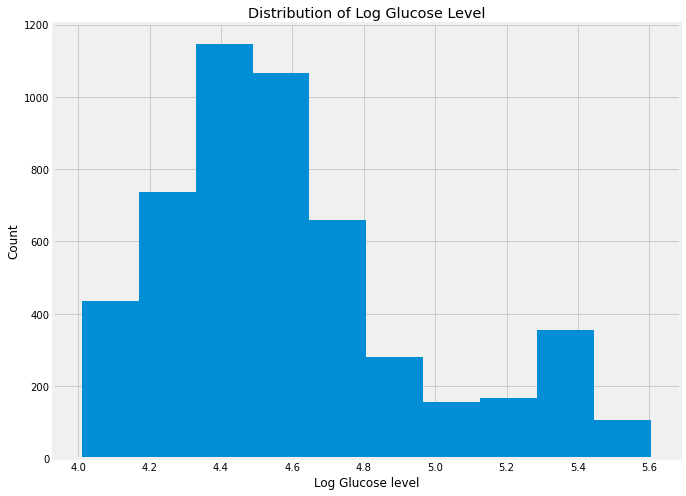

In [49]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist(np.log(stroke_data_complete['avg_glucose_level']))
ax.set_xlabel('Log Glucose level')
ax.set_ylabel('Count')
ax.set_title('Distribution of Log Glucose Level')
plt.show()

It is not exactly normal but skewness has decreased significantly. Now, we are ready to perform the 2 sample t test. It will be interestng to compare the variances for both stroke vs. non-stroke population. One of the key assumptions is the equality of two variances.

In [50]:
stroke_data_complete['log_glucose_level'] = np.log(stroke_data_complete['avg_glucose_level'])
stroke_popn_glucose = stroke_data_complete.loc[stroke_data_complete.stroke==1]['log_glucose_level']
non_stroke_popn_glucose = stroke_data_complete.loc[stroke_data_complete.stroke==0]['log_glucose_level']
print(np.var(stroke_popn_glucose), np.var(non_stroke_popn_glucose))
                                                   

0.21321583 0.12490617


So the two populations (stroke vs. non-stroke) have different variances. So a 2 sample t-test might not be suitable. For sake of convenience, lets try it first. Then we 'll also try the nonpooled t test, which is meant for unequal variances.

In [51]:
t, p = stats.ttest_ind(stroke_popn_glucose,non_stroke_popn_glucose)
print(t,p)

8.42488958648187 4.642142676982856e-17


By default is is a two tailed test. Since the p-value is significantky lower than 0.05,  we conclude that the average glucose levl is statistically different for stroke vs. non-stroke patients. 

In [52]:
#what if we put the equal variance assumption as false, notice that default is true
stats.ttest_ind(stroke_popn_glucose, non_stroke_popn_glucose, equal_var = False)

Ttest_indResult(statistic=6.614032531085487, pvalue=2.0791172077019577e-10)

As mentioned in the scipy documentation, if we violate equality of varainces assumption, p value is underestimated. But we still see statistical significance. Next, we'll try to obtain confidence interval. Since scipy doesn't have an inbuilt function to give the confidence interval for 2 sample t test(also called pooled test), we'll write a functon for this purpose. Notice that the formula to calculate the 95 % confidence interval is given by

$$m_{1} -m_{2} \pm t_{\frac{\alpha}{2}} \cdot s_{p} \sqrt{\frac{1}{n_{1}}+\frac{1}{n_{2}}}$$



Here $m_{1}$ and $m_{2}$ are sample means, $n_{1}$ and $n_{2}$ are sample sizes, whereas $s_{p}$ is pooled standard deviation. 

In [53]:
def conf_interval(x1, x2):
    var1 = np.var(x1)
    var2 = np.var(x2)
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    n1 = x1.size
    n2 = x2.size
    df = n1+n2-2
    s_p = math.sqrt((((n1-1)*var1)+((n2-1)*var2))/(df))
    mean_diff = m1-m2
    low = mean_diff - (stats.t.ppf(0.975,df) * s_p * math.sqrt((1/n1) + (1/n2)))
    high = mean_diff + (stats.t.ppf(0.975,df) * s_p * math.sqrt((1/n1) + (1/n2)))
    return low, high
    

In [54]:
conf_interval(stroke_popn_glucose, non_stroke_popn_glucose)

(0.15102523908262463, 0.2425952519452074)

The 95 percent confidence interval does not include 0,hence aligns with the concusion obtained above, that the average glucose level is statistically different for stroke vs. non-stroke populations. This points us in the direction that glucose level can be a useful predictor for the prediction purposes.

On a side note, we can check are the distributions really normal, otherwise t-test can't be used safely. One way to check whther these samples come from normal distribution is Kolmogorov Smirnov test, where null hypothesis says that these samples are from normal populations.

In [55]:
print(stats.kstest(stroke_popn_glucose, 'norm'))
print(stats.kstest(non_stroke_popn_glucose, 'norm'))

KstestResult(statistic=0.9999717911891906, pvalue=0.0)
KstestResult(statistic=0.9999695778741224, pvalue=0.0)


Looking at the p-values obtained above, it seems these samples are not obtained from normal populations. One option is to use nonparametric tests, which is independent of distribution assumptions. Using Mann whitney test, we also conlcude that the glucose level is statistically different for stroke vs. non-stroke patients.

In [56]:
stats.mannwhitneyu(stroke_popn_glucose,
                   non_stroke_popn_glucose,
                   use_continuity=True,
                   alternative='greater')

MannwhitneyuResult(statistic=739058.0, pvalue=1.7915474936348858e-09)


**Next Steps**

Now that we did some statisticl testing, we'll make a logistic regression model without accounting for skewness in the dataset, and get some baseline performance.

## Train Logistic Regression Model 1

To begin with, we'll just use original features as it is. We will take log of glucose level to have normality assumptions satisfied. We'll check with BMI also.

In [10]:
#take log of glucose level
stroke_data_complete['log_glucose_level'] = np.log(stroke_data_complete['avg_glucose_level'])

In [11]:
features_list = ['gender','hypertension','ever_married', 'work_type', 'Residence_type', 'smoking_status',\
                'heart_disease', 'bmi','log_glucose_level']

In [12]:
#perform the train-test split
X = stroke_data_complete[features_list].copy()
Y = stroke_data_complete['stroke'].copy()

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)
X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state= 42,\
                                                          stratify= Y_train)

### One Hot Encoding
Once the split is done we'll perform the one-hot encoding in order to convert categorical variables into numeric.

In [19]:
enc = OneHotEncoder(dtype = 'int32',handle_unknown = 'ignore')
print(enc);

OneHotEncoder(dtype='int32', handle_unknown='ignore')


In [20]:
enc.fit(X_train_new[features_list[:-2]])
train_data = pd.DataFrame(enc.transform(X_train_new[features_list[:-2]]).toarray(), index= X_train_new.index, \
                          columns = enc.get_feature_names(features_list[:-2]))

In [21]:
train_data['BMI'] = X_train_new['bmi']
train_data['log_glucose_level'] = X_train_new['log_glucose_level']

In [22]:
#next transform the test and validation data
val_data = pd.DataFrame(enc.transform(X_val[features_list[:-2]]).toarray(), index= X_val.index, \
                          columns = enc.get_feature_names(features_list[:-2]))
test_data = pd.DataFrame(enc.transform(X_test[features_list[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list[:-2]))
val_data['BMI'] = X_val['bmi']
val_data['log_glucose_level'] = X_val['log_glucose_level']
test_data['BMI'] = X_test['bmi']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [67]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

clf_1.fit(train_data, Y_train_new)
optimal_clf_1 = clf_1.best_estimator_
train_data_probs = optimal_clf_1.predict_proba(train_data)

In [68]:
print(optimal_clf_1.coef_)

[[-0.57037216 -0.55848764 -1.09171178 -0.03714802 -0.86715708 -0.26170272
   0.17281049 -0.21189278  0.07897134  0.33420748 -1.50295632 -0.64845582
  -0.48040398 -0.37899259 -0.05362638 -0.41404746 -0.28219337 -1.02247914
  -0.10638066 -0.0143074   0.47395359]]


In [69]:
train_data.columns

Index(['gender_Female', 'gender_Male', 'hypertension_0', 'hypertension_1',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'heart_disease_0', 'heart_disease_1', 'BMI',
       'log_glucose_level'],
      dtype='object')

The coefficients for each predictor variable can be observed above.It is not very informative exceptthe fact that patients with high glucose level do have high probaility of stroke. Moreover, it seems work type children do have very less chances of stroke. It is making sense because being around kids might possibly reducd chances of stroke.

Currently the best AUC we are getting is 0.71. Since we plan to predict probabiliites of having a stroke, we'll first perform the  prediction on validation set and try to find optimal threshold, before making predictions on test data.

### Predictions on Training as well as Unseen Data

In [70]:
#Predictions on training data
train_data_probs = optimal_clf_1.predict_proba(train_data)
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(Y_train_new, train_data_probs[:,1])

<Figure size 432x288 with 0 Axes>

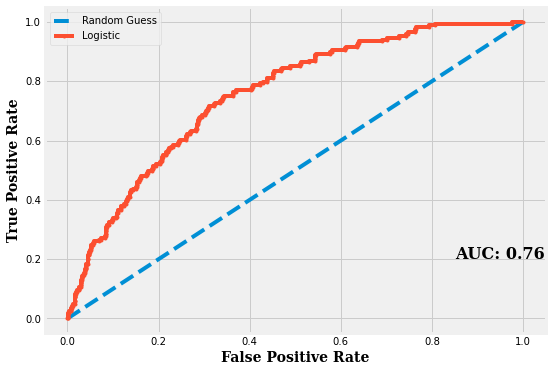

In [71]:
%run -i plot_roc.py
plot_roc(fpr_train, tpr_train, Y_train_new, train_data_probs[:,1])

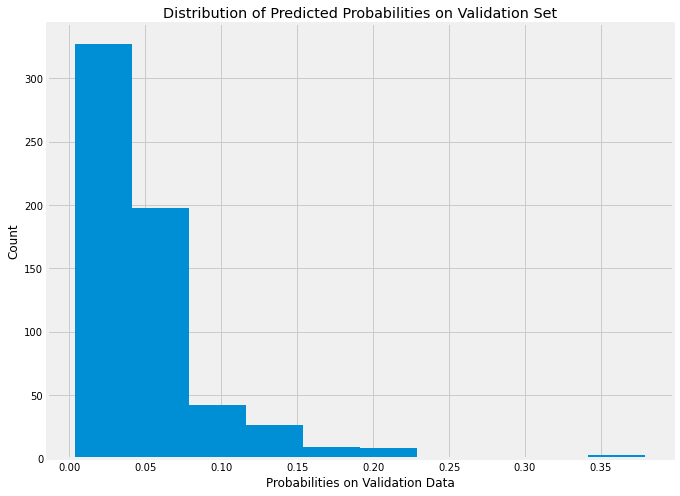

In [72]:
val_data_probs = optimal_clf_1.predict_proba(val_data)
fig,ax = plt.subplots(figsize=(10,8))
ax.hist(val_data_probs[:,1])
ax.set_xlabel('Probabilities on Validation Data')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted Probabilities on Validation Set')
plt.show()

Since it is a stroke prediction data, it will be useful to identify as many cases as possible. In other words, we shd be okay with false positives. So we plan to maximize F1-score.  

In [73]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val, val_data_probs[:,1])

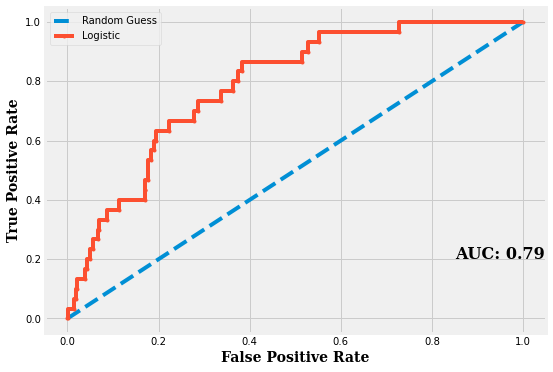

In [74]:
#%run -i plot_roc.py
plot_roc(fpr, tpr, Y_val, val_data_probs[:,1])

We see that the AUC for validation data is slightly higher than on training set. This is good news that we don't suffer from overfitting. 

The ROC curve does not look so impressive, for optimal performance it shd be closer to the left top corner. Next, we'll identify the optimal threhsold to maximize the F1 score.


**Threshold Tuning**

In [75]:
#convert probabiliites to labels for each threshold
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [76]:
thresholds = list(thresholds)[1:]
scores = [metrics.f1_score(Y_val, to_labels(val_data_probs[:,1], t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    

Threshold=0.113, F-Score=0.25000


Looking at the above F score, we don't see much promize in this model. But it is useful in the sense we get a baseline performance here. 




## Bivariate Analysis
### Stroke vs. Gender and Hypertension

In [82]:
gender_hypertension_cnt = stroke_data_complete.groupby(['gender','hypertension'],\
                                                  observed=True)['id'].count()
gender_hypertension_cnt = gender_hypertension_cnt.reset_index()
gender_hypertension_cnt.rename(columns={'id':'Total_Cnt'}, inplace=True)
gender_hypertension_cnt;

In [83]:
gender_hypertension_stroke_cnt = stroke_data_complete.groupby(['gender','hypertension', 'stroke'],\
                                                  observed=True)['id'].count()
gender_hypertension_stroke_cnt = gender_hypertension_stroke_cnt.reset_index()
gender_hypertension_stroke_cnt.rename(columns={'id':'Cases_Cnt'}, inplace=True)
gender_hypertension_stroke_cnt;

In [84]:
gender_hypertension_stroke_merged = pd.merge(gender_hypertension_cnt, gender_hypertension_stroke_cnt, left_on =['gender','hypertension'],\
                    right_on= ['gender','hypertension'], how='inner')
gender_hypertension_stroke_merged['Stroke_pct']  = np.round((gender_hypertension_stroke_merged['Cases_Cnt']/gender_hypertension_stroke_merged['Total_Cnt'])*100,2)
gender_hypertension_stroke_merged

,gender,hypertension,Total_Cnt,stroke,Cases_Cnt,Stroke_pct
0,Male,0,1893,1,81,4.28
1,Male,0,1893,0,1812,95.72
2,Male,1,222,1,27,12.16
3,Male,1,222,0,195,87.84
4,Female,0,2718,1,102,3.75
5,Female,0,2718,0,2616,96.25
6,Female,1,276,1,39,14.13
7,Female,1,276,0,237,85.87


Irrespective of gender, high blood pressure(i.e. hypertension) causes highere occurence of stroke among patients.

### Gender and Smoking vs. Stroke

In [86]:
gender_smoking_cnt = stroke_data_complete.groupby(['gender','smoking_status'],\
                                                  observed=True)['id'].count()
gender_smoking_cnt = gender_smoking_cnt.reset_index()
gender_smoking_cnt.rename(columns={'id':'Total_Cnt'}, inplace=True)

In [87]:
gender_smoking_stroke_cnt = stroke_data_complete.groupby(['gender','smoking_status', 'stroke'],\
                                                  observed=True)['id'].count()
gender_smoking_stroke_cnt = gender_smoking_stroke_cnt.reset_index()
gender_smoking_stroke_cnt.rename(columns={'id':'Cases_Cnt'}, inplace=True)
#gender_hypertension_stroke_cnt

In [88]:
gender_smoking_stroke_merged = pd.merge(gender_smoking_cnt, gender_smoking_stroke_cnt, left_on =['gender','smoking_status'],\
                    right_on= ['gender','smoking_status'], how='inner')
gender_smoking_stroke_merged['Stroke_pct']  = np.round((gender_smoking_stroke_merged['Cases_Cnt']/gender_smoking_stroke_merged['Total_Cnt'])*100,2)
gender_smoking_stroke_merged

,gender,smoking_status,Total_Cnt,stroke,Cases_Cnt,Stroke_pct
0,Male,formerly smoked,407,1,36,8.85
1,Male,formerly smoked,407,0,371,91.15
2,Male,never smoked,663,1,27,4.07
3,Male,never smoked,663,0,636,95.93
4,Male,smokes,337,1,23,6.82
5,Male,smokes,337,0,314,93.18
6,Male,Unknown,708,1,22,3.11
7,Male,Unknown,708,0,686,96.89
8,Female,formerly smoked,477,1,34,7.13
9,Female,formerly smoked,477,0,443,92.87


As the gender transitions from Male to Female, proportion of stroke cases in different smoking buckets don't show much difference.
Do we see any interaction between Hypertension and Smoking status?
### Hypertension and Smoking vs. Stroke 

In [89]:
hyper_smoking_cnt = stroke_data_complete.groupby(['hypertension','smoking_status'],\
                                                  observed=True)['id'].count()
hyper_smoking_cnt = hyper_smoking_cnt.reset_index()
hyper_smoking_cnt.rename(columns={'id':'Total_Cnt'}, inplace=True)

In [90]:
hyper_smoking_stroke_cnt = stroke_data_complete.groupby(['hypertension','smoking_status', 'stroke'],\
                                                  observed=True)['id'].count()
hyper_smoking_stroke_cnt = hyper_smoking_stroke_cnt.reset_index()
hyper_smoking_stroke_cnt.rename(columns={'id':'Cases_Cnt'}, inplace=True)

In [91]:
hyper_smoking_stroke_merged = pd.merge(hyper_smoking_cnt, hyper_smoking_stroke_cnt,\
                                        left_on =['hypertension','smoking_status'],\
                    right_on= ['hypertension','smoking_status'], how='inner')
hyper_smoking_stroke_merged['Stroke_pct']  = np.round((hyper_smoking_stroke_merged['Cases_Cnt']/hyper_smoking_stroke_merged['Total_Cnt'])*100,2)
hyper_smoking_stroke_merged

,hypertension,smoking_status,Total_Cnt,stroke,Cases_Cnt,Stroke_pct
0,0,formerly smoked,764,1,51,6.68
1,0,formerly smoked,764,0,713,93.32
2,0,never smoked,1660,1,58,3.49
3,0,never smoked,1660,0,1602,96.51
4,0,smokes,695,1,31,4.46
5,0,smokes,695,0,664,95.54
6,0,Unknown,1492,1,43,2.88
7,0,Unknown,1492,0,1449,97.12
8,1,formerly smoked,120,1,19,15.83
9,1,formerly smoked,120,0,101,84.17


Above data shows interaction between smoking and hypertension causing stroke. High blood pressure patients who smoke are more likely to suffer from stroke. On a side note, does smoking cause hypertension?

In [92]:
hypertension_cnt = stroke_data_complete.groupby(['hypertension'],\
                                                  observed=True)['id'].count()
hypertension_cnt = hypertension_cnt.reset_index()
hypertension_cnt.rename(columns={'id':'Hyper_Cnt'}, inplace=True)

In [93]:
hyper_smoking_merged = pd.merge(hyper_smoking_cnt, hypertension_cnt,\
                                        left_on =['hypertension'],\
                    right_on= ['hypertension'], how='inner')
hyper_smoking_merged['Hypertension_pct']  = np.round((hyper_smoking_merged['Total_Cnt']/hyper_smoking_merged['Hyper_Cnt'])*100,2)
hyper_smoking_merged

,hypertension,smoking_status,Total_Cnt,Hyper_Cnt,Hypertension_pct
0,0,formerly smoked,764,4611,16.57
1,0,never smoked,1660,4611,36.00
2,0,smokes,695,4611,15.07
3,0,Unknown,1492,4611,32.36
4,1,formerly smoked,120,498,24.10
5,1,never smoked,232,498,46.59
6,1,smokes,94,498,18.88
7,1,Unknown,52,498,10.44


Looking at the above numbers, it doesn't seem so confident that smoking does cause hypertension. For high blood pressure patients, almost half of them are never smokers.

### Heart Disease and Smoking vs. Stroke

In [94]:
heart_disease_smokers_cnt = stroke_data_complete.groupby(['heart_disease','smoking_status'],\
                                                  observed=True)['id'].count()
heart_disease_smokers_cnt = heart_disease_smokers_cnt.reset_index()
heart_disease_smokers_cnt.rename(columns={'id':'heart_disease_smokers_Cnt'}, inplace=True)
heart_disease_smokers_cnt;

In [95]:
heart_disease_smokers_stroke_cnt = stroke_data_complete.groupby(['heart_disease','smoking_status', 'stroke'],\
                                                  observed=True)['id'].count()
heart_disease_smokers_stroke_cnt = heart_disease_smokers_stroke_cnt.reset_index()
heart_disease_smokers_stroke_cnt.rename(columns={'id':'Cases_Cnt'}, inplace=True)
heart_disease_smokers_stroke_cnt;

In [96]:
heart_disease_smokers_stroke_merged = pd.merge(heart_disease_smokers_cnt, heart_disease_smokers_stroke_cnt,\
                                        left_on =['heart_disease','smoking_status'],\
                    right_on= ['heart_disease','smoking_status'], how='inner')
heart_disease_smokers_stroke_merged['Stroke_pct']  = np.round((heart_disease_smokers_stroke_merged['Cases_Cnt']/heart_disease_smokers_stroke_merged['heart_disease_smokers_Cnt'])*100,2)
heart_disease_smokers_stroke_merged

,heart_disease,smoking_status,heart_disease_smokers_Cnt,stroke,Cases_Cnt,Stroke_pct
0,1,formerly smoked,77,1,12,15.58
1,1,formerly smoked,77,0,65,84.42
2,1,never smoked,90,1,12,13.33
3,1,never smoked,90,0,78,86.67
4,1,smokes,61,1,15,24.59
5,1,smokes,61,0,46,75.41
6,1,Unknown,48,1,8,16.67
7,1,Unknown,48,0,40,83.33
8,0,formerly smoked,807,1,58,7.19
9,0,formerly smoked,807,0,749,92.81


Above data shows interaction between smoking and heart disease causing stroke. Heart patients who smoke are more likely to suffer from stroke.

It is worth defining a new feature based on Hypertension and Smoking. Using the various values for Hypertension and Smoking, we define a new feature, which models the interaction. Similarly we define a new feature based on Heart disease and smoking.

In [10]:
#define feature based on Hypertension and smoking

stroke_data_complete.loc[(stroke_data_complete.hypertension==1) & \
                         (stroke_data_complete.smoking_status=='formerly smoked'),'Hypertension_smoking'] = 'High_BP_former_smoker'
stroke_data_complete.loc[(stroke_data_complete.hypertension==1) & \
                         (stroke_data_complete.smoking_status=='never smoked'),'Hypertension_smoking'] ='High_BP_never_smoked'
stroke_data_complete.loc[(stroke_data_complete.hypertension==1) & \
                         (stroke_data_complete.smoking_status=='smokes'),'Hypertension_smoking']='High_BP_smoker'
stroke_data_complete.loc[(stroke_data_complete.hypertension==1) & \
                         (stroke_data_complete.smoking_status=='Unknown'),'Hypertension_smoking']='High_BP_Unknown_smoker'
stroke_data_complete.loc[(stroke_data_complete.hypertension==0) & \
                         (stroke_data_complete.smoking_status=='formerly smoked'),'Hypertension_smoking']='Low_BP_former_smoker'
stroke_data_complete.loc[(stroke_data_complete.hypertension==0) & \
                         (stroke_data_complete.smoking_status=='never smoked'),'Hypertension_smoking']='Low_BP_never_smoked'
stroke_data_complete.loc[(stroke_data_complete.hypertension==0) & \
                         (stroke_data_complete.smoking_status=='smokes'),'Hypertension_smoking']='Low_BP_smoker'
stroke_data_complete.loc[(stroke_data_complete.hypertension==0) & \
                         (stroke_data_complete.smoking_status=='Unknown'),'Hypertension_smoking']='Low_BP_unknown_smoker'

In [11]:
#define feature based on heart disease and smoking

stroke_data_complete.loc[(stroke_data_complete.heart_disease==1) & \
                         (stroke_data_complete.smoking_status=='formerly smoked'),'Heart_disease_smoking'] = 'Heart_former_smoker'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==1) & \
                         (stroke_data_complete.smoking_status=='never smoked'),'Heart_disease_smoking'] ='Heart_never_smoked'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==1) & \
                         (stroke_data_complete.smoking_status=='smokes'),'Heart_disease_smoking']='Heart_smoker'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==1) & \
                         (stroke_data_complete.smoking_status=='Unknown'),'Heart_disease_smoking']='Heart_Unknown'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==0) & \
                         (stroke_data_complete.smoking_status=='formerly smoked'),'Heart_disease_smoking']='Non_heart_former_smoker'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==0) & \
                         (stroke_data_complete.smoking_status=='never smoked'),'Heart_disease_smoking']='Non_heart_never_smoked'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==0) & \
                         (stroke_data_complete.smoking_status=='smokes'),'Heart_disease_smoking']='Non_heart_smoker'
stroke_data_complete.loc[(stroke_data_complete.heart_disease==0) & \
                         (stroke_data_complete.smoking_status=='Unknown'),'Heart_disease_smoking']='Non_heart_unknown_smoker'

In [12]:
#Hypertension smoking and stroke
Smoking_Hypertension_stroke = pd.crosstab(stroke_data_complete['Hypertension_smoking'], stroke_data_complete['stroke'])
stat, p, dof, expected = stats.chi2_contingency(Smoking_Hypertension_stroke)
p

5.044270699281334e-20

In [101]:
cramer_stats_stroke_smoking_hypertension = math.sqrt(stat/(stroke_data_complete.shape[0]*1))
cramer_stats_stroke_smoking_hypertension

0.14433320812131678

In [102]:
#similarly for heart disease smoker and stroke

Smoking_Heart_Disease_stroke = pd.crosstab(stroke_data_complete['Heart_disease_smoking'], stroke_data_complete['stroke'])
stat, p, dof, expected = stats.chi2_contingency(Smoking_Heart_Disease_stroke)
cramer_stats_stroke_smoking_heart_disease = math.sqrt(stat/(stroke_data_complete.shape[0]*1))
cramer_stats_stroke_smoking_heart_disease

0.15808176834566284

Above calculations show that there is significant dependence between stroke variable and these two derived variables.

In [15]:
stroke_data_complete['log_glucose_level'] = np.log(stroke_data_complete['avg_glucose_level'])
stroke_data_complete['log_BMI'] = np.log(stroke_data_complete['bmi'])

## Model 2 with Engineered Features

In [105]:
features_list_3=['gender','ever_married','work_type','Residence_type','Hypertension_smoking','Heart_disease_smoking',
                 'log_glucose_level','log_BMI']

In [106]:
X=stroke_data_complete[features_list_3].copy()
Y=stroke_data_complete['stroke'].copy()

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)
X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state= 42,\
                                                          stratify= Y_train)

In [108]:
#enc = OneHotEncoder(dtype = 'int32',handle_unknown = 'ignore')
enc.fit(X_train_new[features_list_3[:-2]])
train_data = pd.DataFrame(enc.transform(X_train_new[features_list_3[:-2]]).toarray(),\
                          index= X_train_new.index, \
                          columns = enc.get_feature_names(features_list_3[:-2]))

In [109]:
train_data['BMI'] = X_train_new['log_BMI']
train_data['log_glucose_level'] = X_train_new['log_glucose_level']

In [110]:
#next transform the test and validation data
val_data = pd.DataFrame(enc.transform(X_val[features_list_3[:-2]]).toarray(), index= X_val.index, \
                          columns = enc.get_feature_names(features_list_3[:-2]))
test_data = pd.DataFrame(enc.transform(X_test[features_list_3[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list_3[:-2]))
val_data['BMI'] = X_val['log_BMI']
val_data['log_glucose_level'] = X_val['log_glucose_level']
test_data['BMI'] = X_test['log_BMI']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [111]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

clf_1.fit(train_data, Y_train_new)
optimal_clf_1 = clf_1.best_estimator_
val_data_probs = optimal_clf_1.predict_proba(val_data)

<Figure size 432x288 with 0 Axes>

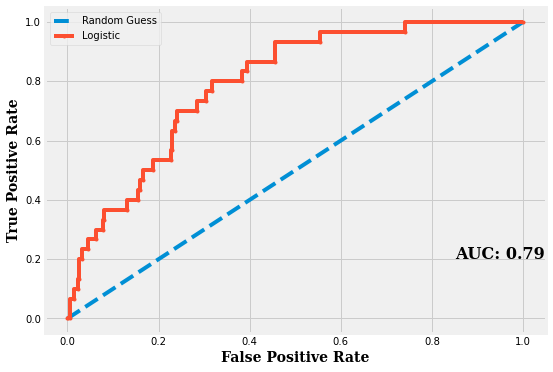

In [112]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val, val_data_probs[:,1])
%run -i plot_roc.py
plot_roc(fpr, tpr, Y_val, val_data_probs[:,1])

In [113]:
features_coef_df = pd.concat([pd.Series(optimal_clf_1.coef_.flatten()),pd.Series(train_data.columns)],axis=1)

In [116]:
features_coef_df.rename(columns={0:'feature_score', 1:'feature_name'},inplace=True)
features_coef_df.sort_values('feature_score',axis=0, ascending=False)

,feature_score,feature_name
22,0.764574,Heart_disease_smoking_Heart_smoker
28,0.504589,log_glucose_level
13,0.492799,Hypertension_smoking_hypertension_never_smoked
14,0.458618,Hypertension_smoking_hypertension_smoker
7,0.366267,work_type_Self-employed
12,0.298916,Hypertension_smoking_hypertension_former_smoker
21,0.235673,Heart_disease_smoking_Heart_never_smoked
4,0.210123,work_type_Govt_job
6,0.120263,work_type_Private
20,0.115102,Heart_disease_smoking_Heart_former_smoker


In decreasing order of coefficients, it seems that Smokers with Heart Disease symptoms do carry high risk of stroke, which is reaonable.Similarly, among work types, Self Employed patients are also at high risk.

If we want to identify the patients at risk, it makes sense to aim at maximizing Recall. 

In [119]:
thresholds = list(thresholds)[1:]
scores = [metrics.recall_score(Y_val, to_labels(val_data_probs[:,1], t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, Recall=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.024, Recall=1.00000


Check the Precision Recall Curve in order to get an idea of the threshold to use so as to balance Precision and Recall.

Text(0.5, 1.0, '2-class Precision Recall Curve')

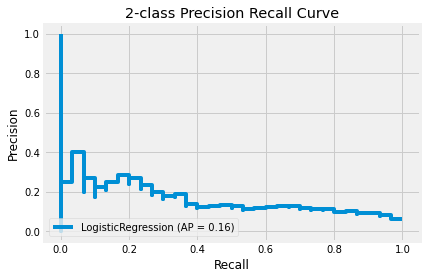

In [118]:
disp = plot_precision_recall_curve(optimal_clf_1, val_data, Y_val)
disp.ax_.set_title('2-class Precision Recall Curve')

Above PR is not at all so optimistic, since the maximum precision we can get is 0.4. And that will force the Recall to be really low.

**Next Idea**:

* Try to use some sort of sampling, in order to balance the data.


Make sure that we try one idea at a time and then check performance. First we'll try random undersampling, which involves throwing away some records from majority class. Then we'll try random oversampling, which involves replicating examples from minority class.

## Model 3 with Sampling Strategy & Engineered Features

### Random Undersampling

In [22]:
# Class count
count_class_0, count_class_1 = stroke_data_complete.stroke.value_counts()

# Divide by class
stroke_data_class_0 = stroke_data_complete[stroke_data_complete['stroke'] == 0]
stroke_data_class_1 = stroke_data_complete[stroke_data_complete['stroke'] == 1]

In [23]:
stroke_class_0_under = stroke_data_class_0.sample(count_class_1)
stroke_data_under = pd.concat([stroke_class_0_under, stroke_data_class_1], axis=0)

In [24]:
stroke_data_under['stroke'].value_counts()

1    249
0    249
Name: stroke, dtype: int64

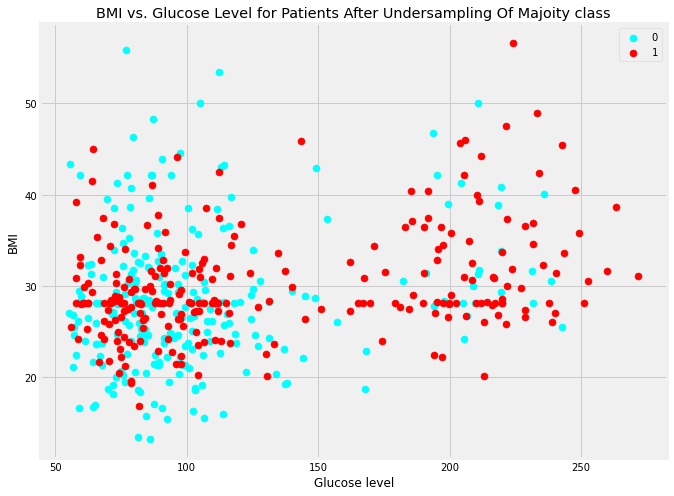

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
colormap = np.array(['aqua','r'])
#for i in [0,1]:
#ax.scatter(x= stroke_data_complete['avg_glucose_level'], y=stroke_data_complete['bmi'], \
 #          c=colormap[stroke_data_complete['stroke']],marker= 'o', s=50 )

for i in [0,1]:
    ax.scatter(x= stroke_data_under['avg_glucose_level'][stroke_data_under['stroke']==i],\
               y=stroke_data_under['bmi'][stroke_data_under['stroke']==i], \
               c=colormap[i], marker= 'o', s=50, label = i )
    
#plt.gray()
ax.legend()
ax.set_xlabel('Glucose level')
ax.set_ylabel('BMI')
ax.set_title('BMI vs. Glucose Level for Patients After Undersampling Of Majoity class')
plt.show()

In [26]:
features_list_4 = ['gender','ever_married','work_type','Residence_type','Hypertension_smoking','Heart_disease_smoking',
                 'log_glucose_level','log_BMI']

In [27]:
X=stroke_data_under[features_list_4].copy()
Y=stroke_data_under['stroke'].copy()

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)
X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state= 42,\
                                                          stratify= Y_train)

In [29]:
enc = OneHotEncoder(dtype = 'int32',handle_unknown = 'ignore')
enc.fit(X_train_new[features_list_4[:-2]])
train_data = pd.DataFrame(enc.transform(X_train_new[features_list_4[:-2]]).toarray(),\
                          index= X_train_new.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))

In [30]:
train_data['BMI'] = X_train_new['log_BMI']
train_data['log_glucose_level'] = X_train_new['log_glucose_level']

In [31]:
#next transform the test and validation data
val_data = pd.DataFrame(enc.transform(X_val[features_list_4[:-2]]).toarray(), index= X_val.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
test_data = pd.DataFrame(enc.transform(X_test[features_list_4[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
val_data['BMI'] = X_val['log_BMI']
val_data['log_glucose_level'] = X_val['log_glucose_level']
test_data['BMI'] = X_test['log_BMI']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [32]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

clf_1.fit(train_data, Y_train_new)
optimal_clf_1 = clf_1.best_estimator_
val_data_probs = optimal_clf_1.predict_proba(val_data)

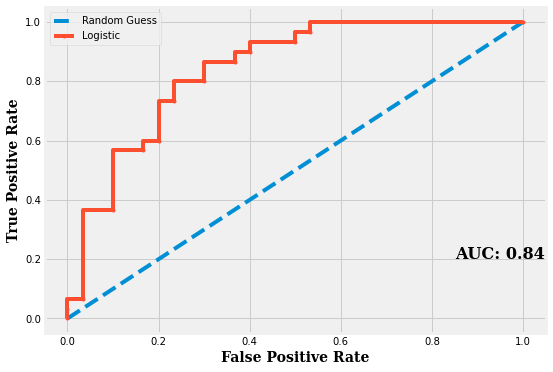

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val, val_data_probs[:,1])
%run -i plot_roc.py
plot_roc(fpr, tpr, Y_val, val_data_probs[:,1])

It seems random undersampling is working. Next, we'll look at random oversampling.

### Random Oversampling

In [38]:
stroke_class_1_over = stroke_data_class_1.sample(count_class_0, replace=True)
stroke_data_over = pd.concat([stroke_class_1_over, stroke_data_class_0], axis=0)

In [40]:
X=stroke_data_over[features_list_4].copy()
Y=stroke_data_over['stroke'].copy()

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)
X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state= 42,\
                                                          stratify= Y_train)

In [42]:
enc = OneHotEncoder(dtype = 'int32',handle_unknown = 'ignore')
enc.fit(X_train_new[features_list_4[:-2]])
train_data = pd.DataFrame(enc.transform(X_train_new[features_list_4[:-2]]).toarray(),\
                          index= X_train_new.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
train_data['BMI'] = X_train_new['log_BMI']
train_data['log_glucose_level'] = X_train_new['log_glucose_level']

In [44]:
#next transform the test and validation data
val_data = pd.DataFrame(enc.transform(X_val[features_list_4[:-2]]).toarray(), index= X_val.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
test_data = pd.DataFrame(enc.transform(X_test[features_list_4[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
val_data['BMI'] = X_val['log_BMI']
val_data['log_glucose_level'] = X_val['log_glucose_level']
test_data['BMI'] = X_test['log_BMI']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [45]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

clf_1.fit(train_data, Y_train_new)
optimal_clf_1 = clf_1.best_estimator_
val_data_probs = optimal_clf_1.predict_proba(val_data)

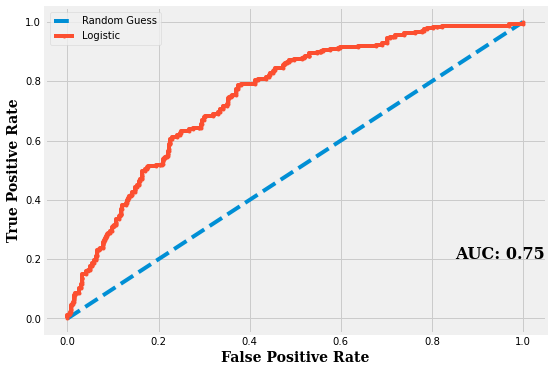

In [46]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val, val_data_probs[:,1])
#%run -i plot_roc.py
plot_roc(fpr, tpr, Y_val, val_data_probs[:,1])

Above ROC is smooth since data size is larger than the one we used in undersampling. The prevous ROC curve was steep due to small dataset.

### Random Undersampling With Tomeklinks

Using Tomeklinks, we consider pairs of instances with opposite classes, and remove the instance from majority class. This involves undersampling of majority class, and helps to defin the class boundary more precisely. 

In [54]:
from imblearn.under_sampling import TomekLinks

In [74]:
tl = TomekLinks(sampling_strategy='majority')



In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)
X_train_new, X_val, Y_train_new, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state= 42,\
                                                          stratify= Y_train)

In [68]:
enc = OneHotEncoder(dtype = 'int32',handle_unknown = 'ignore')
enc.fit(X_train_new[features_list_4[:-2]])
train_data = pd.DataFrame(enc.transform(X_train_new[features_list_4[:-2]]).toarray(),\
                          index= X_train_new.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
train_data['BMI'] = X_train_new['log_BMI']
train_data['log_glucose_level'] = X_train_new['log_glucose_level']

In [70]:
#next transform the test and validation data
val_data = pd.DataFrame(enc.transform(X_val[features_list_4[:-2]]).toarray(), index= X_val.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
test_data = pd.DataFrame(enc.transform(X_test[features_list_4[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list_4[:-2]))
val_data['BMI'] = X_val['log_BMI']
val_data['log_glucose_level'] = X_val['log_glucose_level']
test_data['BMI'] = X_test['log_BMI']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [76]:
X_res, y_res = tl.fit_resample(train_data, Y_train_new)

In [77]:
y_res.value_counts()

0    3212
1     169
Name: stroke, dtype: int64

In [80]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

clf_1.fit(X_res, y_res)
optimal_clf_1 = clf_1.best_estimator_
val_data_probs = optimal_clf_1.predict_proba(val_data)

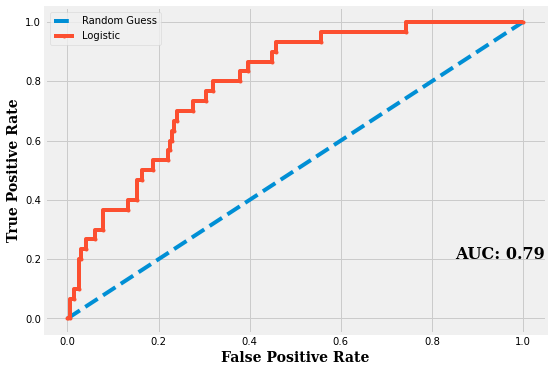

In [81]:
fpr, tpr, thresholds = metrics.roc_curve(Y_val, val_data_probs[:,1])
#%run -i plot_roc.py
plot_roc(fpr, tpr, Y_val, val_data_probs[:,1])

But it seems the class performance doesn't improve too much, the AUC is still the same as before.

**Next ideas**
* One more idea to try, scale BMI and glucose level using standardization and normalization.
* Use stacking also, with predictions from model 1 being together with raw data as input for training in model 2.

## Model 4: Scale Numeric Features 

Since BMI is normally distributed, we perform standardization, means convert to transformed feature with mean 0 and standard deviation as 1. It ivolves following computations;

$$z=\frac{X-\mu}{\sigma}$$

where $X$ is the feature, $\mu$ is the mean, and $\sigma$ is standard deviation of $X.$ We are using same feature set as in model 1, the only differnce being we are using scaled version of BMI.

In [15]:
stroke_data_complete['bmi_scaled'] = (stroke_data_complete['bmi'] -\
                                      stroke_data_complete['bmi'].mean())/stroke_data_complete['bmi'].std()

In [16]:
stroke_data_complete['bmi_scaled'].describe()

count    5.109000e+03
mean     2.150387e-07
std      9.999999e-01
min     -2.410885e+00
25%     -6.575897e-01
50%     -9.913238e-02
75%      5.112741e-01
max      8.927094e+00
Name: bmi_scaled, dtype: float64

We'll perform standardization on training set. Using the same mean and standard deviation parameters, we'll standardize test as well as validation set.

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)


In [40]:
bmi_mean = X_train['bmi'].mean()
bmi_std = X_train['bmi'].std()
X_train['bmi_scaled'] = (X_train['bmi'] - bmi_mean)/bmi_std

In [41]:
X_train.columns

Index(['gender', 'hypertension', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status', 'heart_disease', 'bmi', 'log_glucose_level',
       'bmi_scaled'],
      dtype='object')

Using features_list introduced in model 1, we'll perform one hot encoding for train as well as validation data.

In [42]:
enc.fit(X_train[features_list[:-2]])
train_data = pd.DataFrame(enc.transform(X_train[features_list[:-2]]).toarray(), index= X_train.index, \
                          columns = enc.get_feature_names(features_list[:-2]))

In [43]:
train_data['BMI'] = X_train['bmi_scaled']
train_data['log_glucose_level'] = X_train['log_glucose_level']

In [46]:
X_test['bmi_scaled'] = (X_test['bmi'] - bmi_mean)/bmi_std


In [49]:
#next transform the test and validation data

test_data = pd.DataFrame(enc.transform(X_test[features_list[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list[:-2]))
test_data['BMI'] = X_test['bmi_scaled']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [50]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_5 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

clf_5.fit(train_data, Y_train)

optimal_clf_5 = clf_5.best_estimator_
#train_data_probs = optimal_clf_1.predict_proba(train_data)

{'mean_fit_time': array([0.00702362, 0.00731397, 0.00980477, 0.0110218 , 0.01186786,
       0.01235194, 0.0133564 ]), 'std_fit_time': array([0.00025228, 0.00017998, 0.00264897, 0.00245244, 0.00058967,
       0.00042391, 0.00030536]), 'mean_score_time': array([0.00367584, 0.00367489, 0.00364084, 0.00413027, 0.00525284,
       0.00302062, 0.00296397]), 'std_score_time': array([1.79346981e-04, 1.40932011e-04, 2.10130477e-04, 8.50494067e-04,
       3.31273094e-03, 9.98433247e-05, 4.70714360e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 500],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 500}], 'split0_test_score': array([0.48984576, 0.65767995, 0.69932519, 0.71658098, 0.71436375,
       0.71397815, 0.71388175]), 'split1_test_score': array([0.42062982, 0.6561054 , 0.72840617, 0.76969794, 0.77130463,
       0.77

In [52]:
score_dict = clf_5.cv_results_
pd.DataFrame(score_dict)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007024,0.000252,0.003676,0.000179,0.001,{'C': 0.001},0.489846,0.420630,0.493310,0.438546,0.514704,0.471407,0.035644,7
1,0.007314,0.000180,0.003675,0.000141,0.01,{'C': 0.01},0.657680,0.656105,0.668282,0.651963,0.650193,0.656845,0.006327,6
2,0.009805,0.002649,0.003641,0.000210,0.1,{'C': 0.1},0.699325,0.728406,0.720157,0.719981,0.694498,0.712473,0.013155,5
3,0.011022,0.002452,0.004130,0.000850,1,{'C': 1},0.716581,0.769698,0.754960,0.749453,0.708752,0.739889,0.023324,4
4,0.011868,0.000590,0.005253,0.003313,10,{'C': 10},0.714364,0.771305,0.753873,0.753861,0.711358,0.740952,0.023823,1
5,0.012352,0.000424,0.003021,0.000100,100,{'C': 100},0.713978,0.770823,0.752291,0.753797,0.711326,0.740443,0.023621,2
6,0.013356,0.000305,0.002964,0.000047,500,{'C': 500},0.713882,0.770566,0.752093,0.753764,0.711615,0.740384,0.023482,3


Scaling the numeric feature BMI does not seem to have a very significant effect on the model performance. 

## Repeated Kfold Cross Validation

We'll check the metrics for repeated k-fold cross-validation. Everything else will be identical to model 1. We want to check whether the optiml hyperparameter is same for all repetitions.
 

In [23]:
#define range of hyperparameters C

logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
for j in range(0,3):
    regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
    clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)

    clf_1.fit(train_data, Y_train_new)
    optimal_clf_1 = clf_1.best_estimator_
    val_data_probs = optimal_clf_1.predict_proba(val_data)
    print('AUC: {}'.format(round(metrics.roc_auc_score(Y_val, val_data_probs[:,1]),2)))


AUC: 0.79
AUC: 0.79
AUC: 0.79


Above numbers suggest that model performance is quite consistent across different partitioning, thats a good sign.

## Performing Nested Cross Validation

Alternative approach to standard K fold cross validation is nested cross-validation, where we perform cross validation on the test set. In other words, we perform double cross validation, using outer loop as well as inner loop. 

In [20]:
#take log of glucose level
stroke_data_complete['log_glucose_level'] = np.log(stroke_data_complete['avg_glucose_level'])
features_list = ['gender','hypertension','ever_married', 'work_type', 'Residence_type', 'smoking_status',\
                'heart_disease', 'bmi','log_glucose_level']
#perform the train-test split
X = stroke_data_complete[features_list].copy()
Y = stroke_data_complete['stroke'].copy()

In [19]:
stroke_data_complete[['gender', 'ever_married', 'work_type','Residence_type',\
                      'smoking_status', 'stroke']] = stroke_data_complete[['gender', 'ever_married', 'work_type',\
                                                                 'Residence_type', 'smoking_status', 'stroke']].\
                                                                 astype('category')

stroke_data_complete[['hypertension', 'heart_disease']] = stroke_data_complete[['hypertension', 'heart_disease', \
                                                                            ]].astype('category')
stroke_data_complete[['age', 'avg_glucose_level', 'bmi']] = stroke_data_complete[['age', 'avg_glucose_level', \
                                                                                          'bmi']].astype('float32')

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 42, stratify= Y)

In [22]:
enc = OneHotEncoder(dtype = 'int32',handle_unknown = 'ignore')
enc.fit(X_train[features_list[:-2]])
train_data = pd.DataFrame(enc.transform(X_train[features_list[:-2]]).toarray(), index= X_train.index, \
                          columns = enc.get_feature_names(features_list[:-2]))
train_data['BMI'] = X_train['bmi']
train_data['log_glucose_level'] = X_train['log_glucose_level']

In [23]:
test_data = pd.DataFrame(enc.transform(X_test[features_list[:-2]]).toarray(), index= X_test.index, \
                          columns = enc.get_feature_names(features_list[:-2]))
test_data['BMI'] = X_test['bmi']
test_data['log_glucose_level'] = X_test['log_glucose_level']

In [41]:
train_data.head(3)

,gender_Female,gender_Male,hypertension_0,hypertension_1,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,...,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,heart_disease_0,heart_disease_1,BMI,log_glucose_level
845,1,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,33.099998,4.237145
3745,1,0,1,0,1,0,0,0,1,0,...,0,1,0,0,1,0,1,0,21.200001,4.433076
4184,1,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,22.900000,4.782479


In [42]:
from sklearn.model_selection import cross_val_score 

In [43]:
#define range of hyperparameters C
regularization = {'C': [.001, .01, .1, 1, 10, 100, 500]}
logit1 = LogisticRegression(penalty='l2', fit_intercept=True, intercept_scaling = 1, solver = 'liblinear', \
                         multi_class = 'ovr', random_state=42)
clf_1 = GridSearchCV(logit1,
                     regularization,
                     scoring='roc_auc',
                     refit=True,
                     cv=5,
                     verbose=0)
cross_val_score(estimator=clf_1,X=train_data, y=Y_train, cv=3,scoring='roc_auc')



array([0.73189608, 0.7318439 , 0.7265362 ])

Looking at the above metrics, we feel quite confident that the test data distributions are fairly consistent.